In [1]:
import numpy as np
import cv2
import skimage
import matplotlib.pyplot as plt
import src.cp_hw2
# import src.cp_exr

/home/aramesh/anaconda3/envs/comp-photo/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Q1.2) Linearize Rendered Images

# Read images
image_files = ['data/door_stack/exposure'+str(i)+'.jpg' for i in range(1,16)]
images_stack_for_lin = []
for imf in image_files : 
    img = plt.imread(imf)
    img = img[::200, ::200]
    images_stack_for_lin.append(img)
images_stack_for_lin = np.array(images_stack_for_lin)
images_stack_for_lin_reshaped = images_stack_for_lin.reshape(images_stack_for_lin.shape[0],-1).swapaxes(0,1)


In [3]:
t_filler = lambda x : 2.0 ** (x-1-11)
t = [t_filler(i) for i in range(1,17)]
# variable t used in general scope later on in the program
def get_g(images_stack_reshaped, images_stack, w, t, r_l=1, is_w_photon=False) : 
    
    n = 256;
    A = np.zeros((images_stack_reshaped.shape[0]*images_stack_reshaped.shape[1]+n+1,
                  n+images_stack_reshaped.shape[0]))
    b = np.zeros((A.shape[0],1))
    cur_row_A = 0
    for i in range(images_stack_reshaped.shape[0]) : # Corresponds to pixel in image
        for j in range(images_stack_reshaped.shape[1]) : # Corresponds to image in sequence
    #         wt_ij = 1 # placeholder
            if is_w_photon : 
                wt_ij = w(images_stack_reshaped[i,j], t[j])
            else : 
                wt_ij = w(images_stack_reshaped[i,j])
#             print(wt_ij)
            A[cur_row_A, images_stack_reshaped[i,j]] = wt_ij
            A[cur_row_A, n+i-1] = -wt_ij
            b[cur_row_A, 0] = wt_ij * np.log(t[j])
            cur_row_A = cur_row_A + 1

    # Adding the terms corresponding to the smoothing regularization
    for i in range(n) :
        if is_w_photon : 
            wt_i = 1
        else :
            wt_i = w(i)
        A[cur_row_A,i-1] = r_l * wt_i
        A[cur_row_A,i] = -2*r_l*wt_i
        A[cur_row_A,i+1] = r_l*wt_i
        cur_row_A += 1 

    # Normalize the curve by setting its middle value to 0
    A[cur_row_A,128] = 1 # Corresponds to g128 in g0-g255

    v = np.linalg.lstsq(A, b, rcond=None)
#     print(v)
    v_sol = v[0]
    g = v_sol[:n]
#     L = v_sol[n:]
#     L = L.reshape(images_stack.shape[1], images_stack.shape[2], images_stack.shape[3])
    
    return g

w = lambda x: 0.01
g = get_g(images_stack_for_lin_reshaped, images_stack_for_lin, w, t, 10)

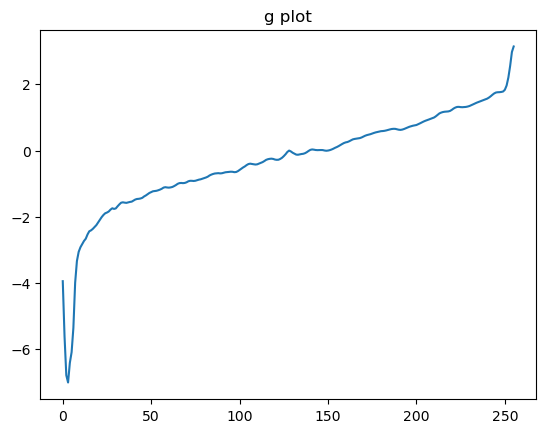

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


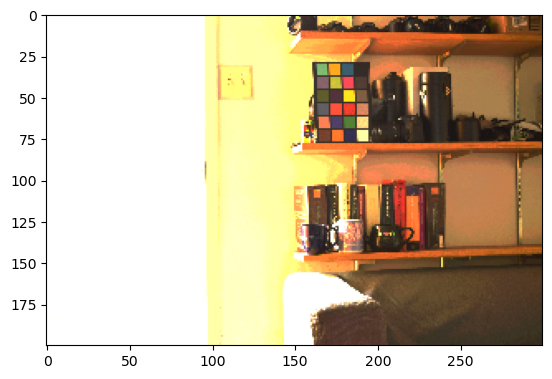

In [4]:
# Plotting g
plt.plot(np.arange(0,256),g)
plt.title('g plot')
plt.show()
# Linearizing the image
# The other image is too small to make sense of, so looking at a larger image
images_stack = []
for imf in image_files : 
    img = plt.imread(imf)
    img = img[::20, ::20]
    images_stack.append(img)
images_stack = np.array(images_stack)

def linearize_image(images_stack, g) : 
    lin_images_stack = np.exp(g[images_stack])
    lin_images_stack = lin_images_stack.squeeze(-1)
    return lin_images_stack

lin_images_stack = linearize_image(images_stack, g)
plt.imshow(lin_images_stack[14])
# display_hdr_image(lin_images_stack[8],0.05)

In [5]:
# Q1.3) Merge exposure stack into HDR image (30 points)
# We've already loaded .jpg images. Lets load .tiff images as well.
image_files_tiff = ['data/door_stack/exposure'+str(i)+'.tiff' for i in range(1,16)]
images_stack_tiff = []
for imf in image_files_tiff :
    img = plt.imread(imf)
    img = img[::20, ::20]
    images_stack_tiff.append(img)
images_stack_tiff = np.array(images_stack_tiff)

In [6]:
images_stack_normalized = images_stack / 255.0
images_stack_tiff_normalized = images_stack_tiff * 255.0 / (2**16 - 1)
# 
# Over-exposure vs under-exposed pixel selection is still off. Fix later!
def linear_merging(im_s, lin_im_s, t, w_v, is_w_photon=False) :
    
    I_hdr_num = np.zeros(im_s[0].shape)
    I_hdr_den = np.zeros(im_s[0].shape)
    for k in range(len(im_s)) :
        if is_w_photon : 
            w_v_imk = w_v(im_s[k],t[k])
        else : 
            w_v_imk = w_v(im_s[k])
        I_hdr_num += (w_v_imk * lin_im_s[k] / t[k] ) 
        I_hdr_den += (w_v_imk)
    
    I_hdr = I_hdr_num / I_hdr_den
    
    # where num is zero, hdr final should also be zero
    I_hdr_num_zero = np.where(I_hdr_num == 0)
    if len(I_hdr_num_zero) == 3 : 
        I_hdr_num_zero = np.vstack((np.vstack((I_hdr_num_zero[0],I_hdr_num_zero[1])), I_hdr_num_zero[2])).T
    else : 
        I_hdr_num_zero = np.vstack((I_hdr_num_zero[0],I_hdr_num_zero[1])).T
        
        
    # where num is not zero, but den is zero, all hdr final values should be max val
    I_hdr_den_zero = np.where(I_hdr_den == 0)
    if len(I_hdr_den_zero) == 3 : 
        I_hdr_den_zero = np.vstack((np.vstack((I_hdr_den_zero[0],I_hdr_den_zero[1])), I_hdr_den_zero[2])).T
    else : 
        I_hdr_den_zero = np.vstack((I_hdr_den_zero[0],I_hdr_den_zero[1])).T
    
    I_hdr_max_val = []
    
    if I_hdr_num_zero.size > 0 :
        if len(I_hdr.shape) == 3 : 
            I_hdr[I_hdr_num_zero[:,0],I_hdr_num_zero[:,1],I_hdr_num_zero[:,2]] = 0
        else : 
            I_hdr[I_hdr_num_zero[:,0],I_hdr_num_zero[:,1]] = 0
    
    if I_hdr_den_zero.size > 0 :
        for index in I_hdr_den_zero :
            if len(I_hdr.shape) == 3 : 
                if I_hdr_num[index[0],index[1],index[2]] != 0 :
                    I_hdr_max_val.append(index)
            else : 
                if I_hdr_num[index[0],index[1]] != 0 :
                    I_hdr_max_val.append(index)
                
        I_hdr_max_val = np.array(I_hdr_max_val).T
        if I_hdr_max_val.size > 0 :
            if len(I_hdr.shape) == 3 : 
                I_hdr[I_hdr_max_val[:,0],I_hdr_max_val[:,1],I_hdr_max_val[:,2]] = I_hdr.nanmax()
            else : 
                I_hdr[I_hdr_max_val[:,0],I_hdr_max_val[:,1]] = I_hdr.nanmax()
    
    return I_hdr

def linear_merging_channelwise(im_s, lin_im_s, t, w_v, is_w_photon=False) :
    
    I_hdr = np.zeros(im_s[0].shape)
    I_hdr[...,0] = linear_merging(im_s[...,0], lin_im_s[...,0], t, w_v, is_w_photon)
    I_hdr[...,1] = linear_merging(im_s[...,1], lin_im_s[...,1], t, w_v, is_w_photon)
    I_hdr[...,2] = linear_merging(im_s[...,2], lin_im_s[...,2], t, w_v, is_w_photon)

    return I_hdr

def log_merging(im_s, lin_im_s, t, w_v, is_w_photon=False) :
    
    eps = 1e-8
    I_hdr_num = np.zeros(im_s[0].shape)
    I_hdr_den = np.zeros(im_s[0].shape)
    for k in range(len(im_s)) :
        
        if is_w_photon : 
            w_v_imk = w_v(im_s[k],t[k])
        else : 
            w_v_imk = w_v(im_s[k])
        I_hdr_num += ( w_v_imk * ( np.log(lin_im_s[k] + eps) - np.log(t[k]))) 
        I_hdr_den += w_v_imk
        
    I_hdr = I_hdr_num / I_hdr_den
    # where num is zero, hdr final should also be zero (regardless of den)
    I_hdr_num_zero = np.where(I_hdr_num == 0)
    I_hdr_num_zero = np.vstack((np.vstack((I_hdr_num_zero[0],I_hdr_num_zero[1])), I_hdr_num_zero[2])).T
    
    # where num is not zero, but den is zero, all hdr final values should be max val
    I_hdr_den_zero = np.where(I_hdr_den == 0)
    I_hdr_den_zero = np.vstack((np.vstack((I_hdr_den_zero[0],I_hdr_den_zero[1])), I_hdr_den_zero[2])).T
    I_hdr_max_val = []
    
    if I_hdr_num_zero.size > 0 :
        I_hdr[I_hdr_num_zero[:,0],I_hdr_num_zero[:,1],I_hdr_num_zero[:,2]] = 0
    
    if I_hdr_den_zero.size > 0 :
        for index in I_hdr_den_zero :
            if I_hdr_num[index[0],index[1],index[2]] != 0 :
                I_hdr_max_val.append(index)
        I_hdr_max_val = np.array(I_hdr_max_val).T
        if I_hdr_max_val.size > 0 :
            I_hdr[I_hdr_max_val[:,0],I_hdr_max_val[:,1],I_hdr_max_val[:,2]] = I_hdr.nanmax()
    
    return I_hdr

# setting w for merging testing
w_v = np.vectorize(w)

I_hdr_lin_merged = linear_merging(images_stack_normalized, lin_images_stack, t, w_v)
I_hdr_tiff_lin_merged = linear_merging(images_stack_tiff_normalized, images_stack_tiff, t, w_v)

I_hdr_log_merged = log_merging(images_stack_normalized, lin_images_stack, t, w_v)
I_hdr_tiff_log_merged = log_merging(images_stack_tiff_normalized, images_stack_tiff, t, w_v)

src.cp_hw2.writeHDR('I_jpg_lin_merged.HDR', I_hdr_lin_merged)
src.cp_hw2.writeHDR('I_tiff_lin_merged.HDR', I_hdr_tiff_lin_merged)

src.cp_hw2.writeHDR('I_jpg_log_merged.HDR', I_hdr_log_merged)
src.cp_hw2.writeHDR('I_tiff_log_merged.HDR', I_hdr_tiff_log_merged)

In [7]:
# Weighting Schemes
def w_uniform(z, Z_min = 0.05, Z_max=0.95) : 
    if isinstance(z,np.uint8) or isinstance(z,int): 
        z = z / 255.0
    if Z_min <= z <= Z_max :
        return 1
    return 0

def w_tent(z, Z_min = 0.05, Z_max=0.95) :
    if isinstance(z,np.uint8) or isinstance(z,int) : 
        z = z / 255.0
    if Z_min <= z <= Z_max :
        return np.min([z, 1.0-z])
    return 0

def w_gaussian(z, Z_min = 0.05, Z_max=0.95) :
    if isinstance(z,np.uint8) or isinstance(z,int): 
        z = z / 255.0
    if Z_min <= z <= Z_max :
        return np.exp(-4 * (((z-0.5)**2) / ((0.5)**2)))
    return 0

def w_photon(z, tk, Z_min = 0.05, Z_max=0.95) : 
    if isinstance(z,np.uint8) or isinstance(z,int): 
        z = z / 255.0
    if Z_min <= z <= Z_max :
        return tk
    return 0

# current unused, for debugging
def w_photon_2(im, tk, Z_min=0.05, Z_max=0.95) :
    zeros_indices_1 = np.where(im > 0.95)
    zeros_indices_2 = np.where(im < 0.5)
    zeros_indices = np.hstack((zeros_indices_1, zeros_indices_2))

    tk_indices = np.where(im[np.where(im<=Z_max)]>=Z_min)

    im[tk_indices] = tk
    im[zeros_indices] = 0
    
    return im
    

In [8]:
# HDR display util functions
def linear_scaling(img_cc, scale, should_plot=False):
#     img_scaled = np.clip(skimage.color.rgb2gray(img_cc) * scale, 0, 1)
    img_scaled = np.clip(img_cc * scale, 0, 1)
    if should_plot : 
        plt.imshow(img_scaled)
        plt.title('linear scaling')
        plt.show()
    return img_scaled

# Gamma Encoding
def gamma_encoding(val) : 
    if val <= 0.0031308 : 
        return 12.92 * val
    else : 
        return (1+0.055) * np.power(val, 1/2.4) - 0.055

def display_hdr_image(img, scale, title='', should_plot=True) : 
    img_scaled = linear_scaling(img, scale)
    ge_f = np.vectorize(gamma_encoding)
    image_ge = ge_f(img_scaled)
    if should_plot : 
        plt.imshow(image_ge)
        plt.title(title)
        plt.show()
    return image_ge

In [9]:
w_uniform_vectorized = np.vectorize(w_uniform)
w_tent_vectorized = np.vectorize(w_tent)
w_gaussian_vectorized = np.vectorize(w_gaussian)
w_photon_vectorized = np.vectorize(w_photon)

# Creating all merged raw images
I_hdr_tiff_lin_merged_w_uniform = linear_merging(images_stack_tiff_normalized, images_stack_tiff, t, w_uniform_vectorized)
I_hdr_tiff_lin_merged_w_uniform_channelwise = linear_merging_channelwise(images_stack_tiff_normalized, images_stack_tiff, t, w_uniform_vectorized)
I_hdr_tiff_log_merged_w_uniform = log_merging(images_stack_tiff_normalized, images_stack_tiff, t, w_uniform_vectorized)

I_hdr_tiff_lin_merged_w_tent = linear_merging(images_stack_tiff_normalized, images_stack_tiff, t, w_tent_vectorized)
I_hdr_tiff_log_merged_w_tent = log_merging(images_stack_tiff_normalized, images_stack_tiff, t, w_tent_vectorized)

I_hdr_tiff_lin_merged_w_gaussian = linear_merging(images_stack_tiff_normalized, images_stack_tiff, t, w_gaussian_vectorized)
I_hdr_tiff_log_merged_w_gaussian = log_merging(images_stack_tiff_normalized, images_stack_tiff, t, w_gaussian_vectorized)

I_hdr_tiff_lin_merged_w_photon = linear_merging(images_stack_tiff_normalized, images_stack_tiff, t, w_photon_vectorized, is_w_photon=True)
I_hdr_tiff_log_merged_w_photon = log_merging(images_stack_tiff_normalized, images_stack_tiff, t, w_photon_vectorized, is_w_photon=True)

/tmp/ipykernel_24621/2431530296.py:17: RuntimeWarning: invalid value encountered in divide
  I_hdr = I_hdr_num / I_hdr_den
/tmp/ipykernel_24621/2431530296.py:83: RuntimeWarning: invalid value encountered in divide
  I_hdr = I_hdr_num / I_hdr_den


In [10]:
# Creating all merged jpeg images

g_uniform = get_g(images_stack_for_lin_reshaped, images_stack_for_lin, w_uniform_vectorized,t, 10)
g_tent = get_g(images_stack_for_lin_reshaped, images_stack_for_lin, w_tent_vectorized,t, 10)
g_gaussian = get_g(images_stack_for_lin_reshaped, images_stack_for_lin, w_gaussian_vectorized,t, 10)
g_photon = get_g(images_stack_for_lin_reshaped, images_stack_for_lin, w_photon_vectorized,t, 10, is_w_photon=True)

lin_images_stack_uniform = linearize_image(images_stack, g_uniform)
lin_images_stack_tent = linearize_image(images_stack, g_tent)
lin_images_stack_gaussian = linearize_image(images_stack, g_gaussian)
lin_images_stack_photon = linearize_image(images_stack, g_photon)

I_hdr_jpeg_lin_merged_w_uniform = linear_merging(images_stack_normalized, lin_images_stack_uniform, t, w_uniform_vectorized)
I_hdr_jpeg_log_merged_w_uniform = log_merging(images_stack_normalized, lin_images_stack_uniform, t, w_uniform_vectorized)

I_hdr_jpeg_lin_merged_w_tent = linear_merging(images_stack_normalized, lin_images_stack_tent, t, w_tent_vectorized)
I_hdr_jpeg_log_merged_w_tent = log_merging(images_stack_normalized, lin_images_stack_tent, t, w_tent_vectorized)

I_hdr_jpeg_lin_merged_w_gaussian = linear_merging(images_stack_normalized, lin_images_stack_gaussian, t, w_gaussian_vectorized)
I_hdr_jpeg_log_merged_w_gaussian = log_merging(images_stack_normalized, lin_images_stack_gaussian, t, w_gaussian_vectorized)

I_hdr_jpeg_lin_merged_w_photon = linear_merging(images_stack_normalized, lin_images_stack_photon, t, w_photon_vectorized, is_w_photon=True)
I_hdr_jpeg_log_merged_w_photon = log_merging(images_stack_normalized, lin_images_stack_photon, t, w_photon_vectorized, is_w_photon=True)

/tmp/ipykernel_24621/2431530296.py:17: RuntimeWarning: invalid value encountered in divide
  I_hdr = I_hdr_num / I_hdr_den
/tmp/ipykernel_24621/2431530296.py:83: RuntimeWarning: invalid value encountered in divide
  I_hdr = I_hdr_num / I_hdr_den


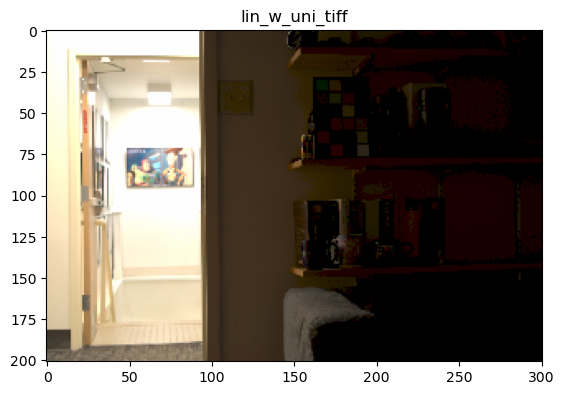

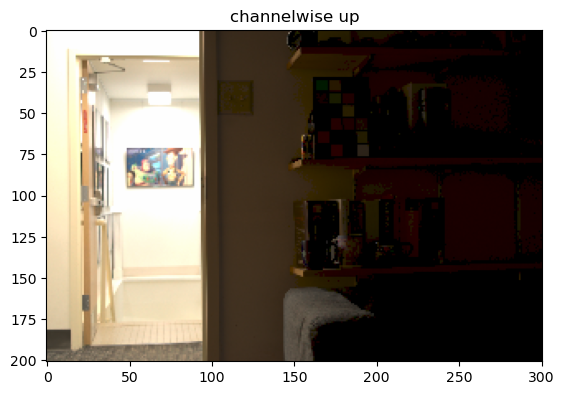

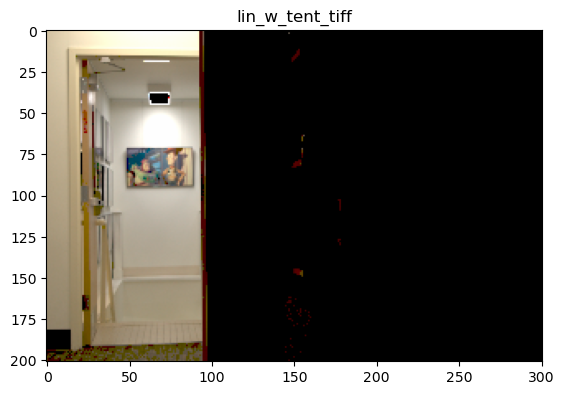

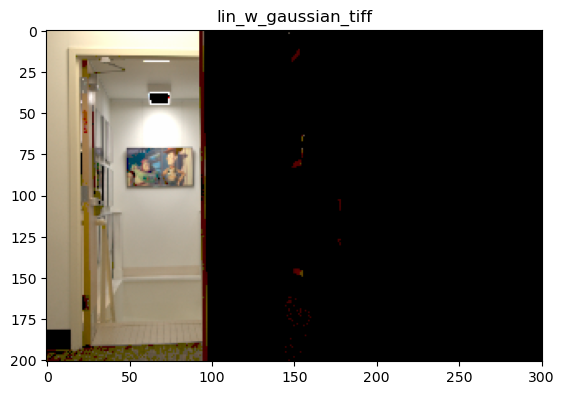

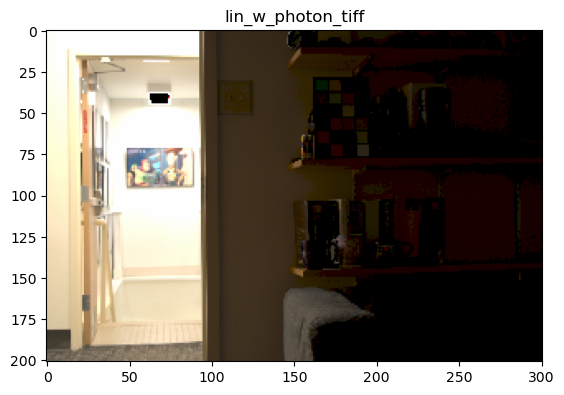

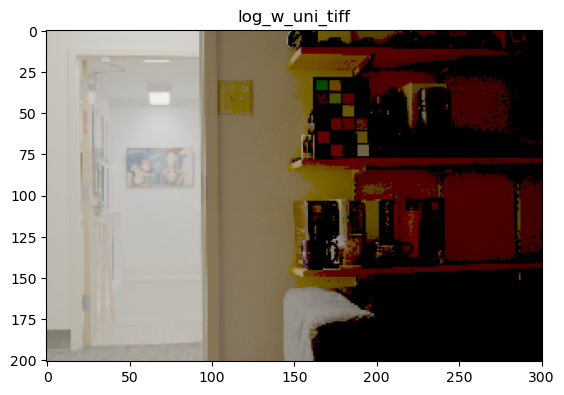

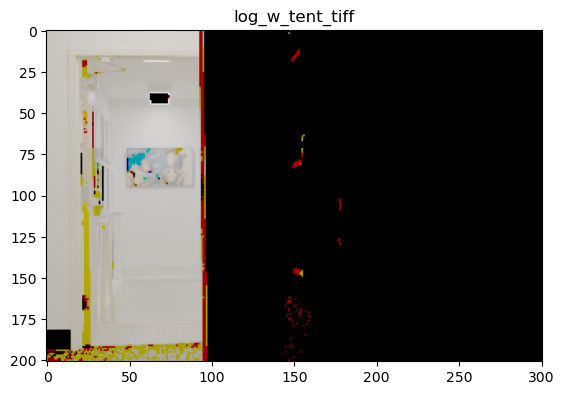

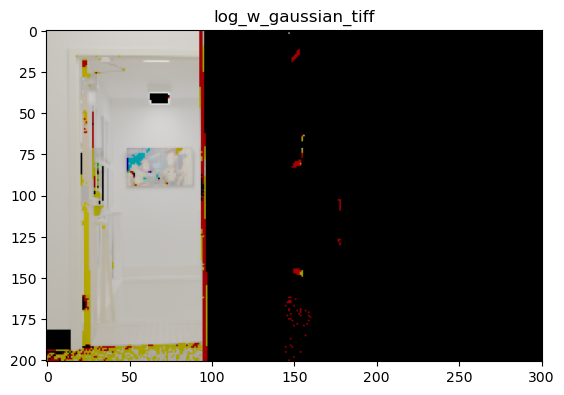

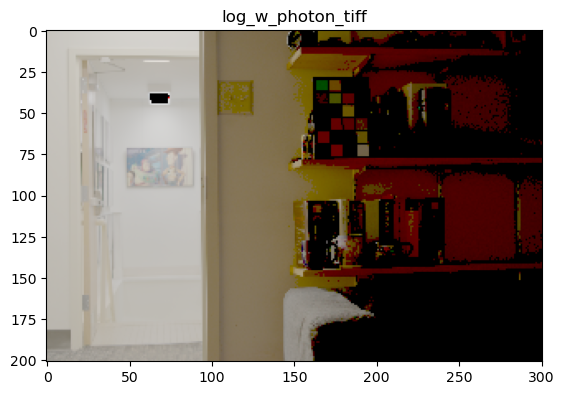

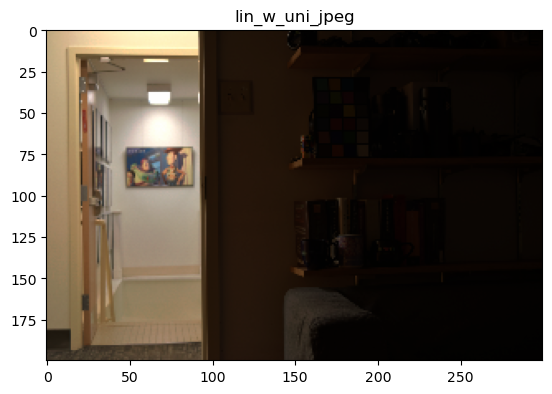

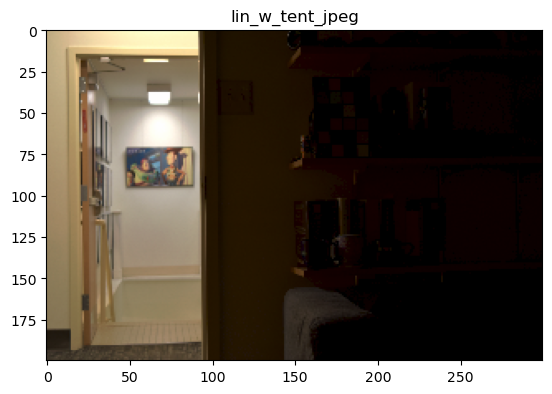

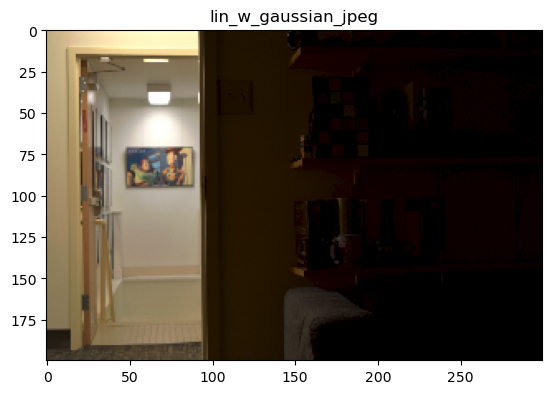

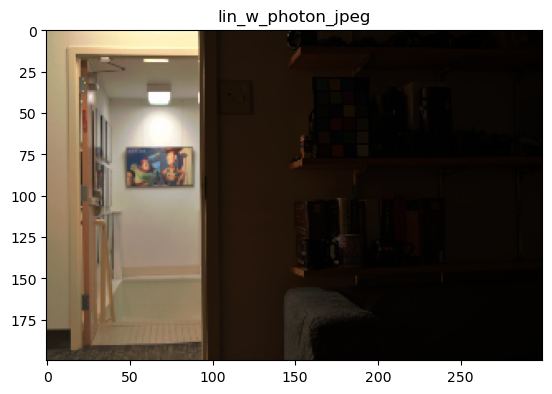

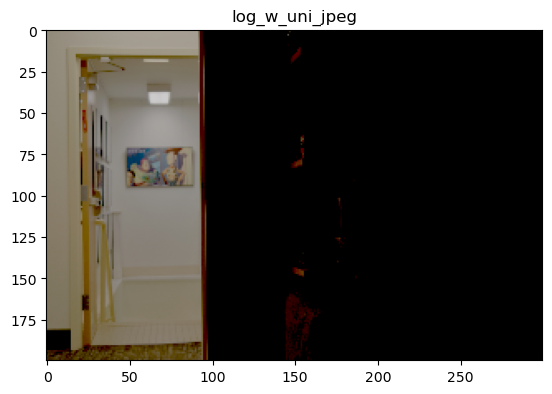

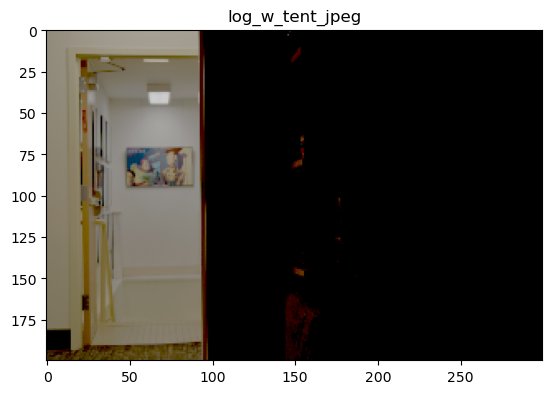

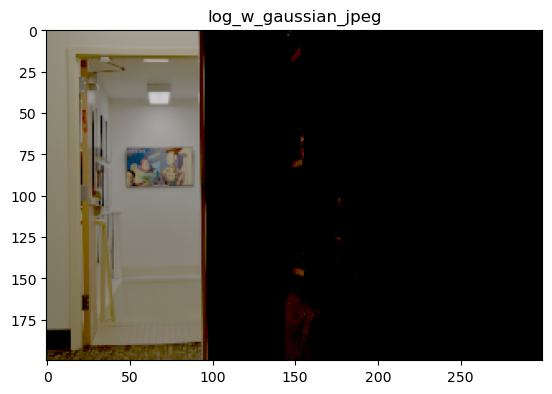

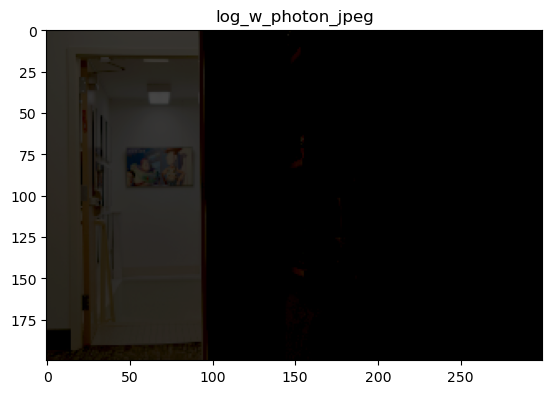

lin_w_uni_tiff and lin_w_photon_tiff are the two best images, out of which the uniform weighing scheme image is picked.


In [11]:
# Displaying images
# Displaying RAW source generated images
_ = display_hdr_image(I_hdr_tiff_lin_merged_w_uniform,0.005,'lin_w_uni_tiff')
_ = display_hdr_image(I_hdr_tiff_lin_merged_w_uniform_channelwise, 0.005, 'channelwise up')
_ = display_hdr_image(I_hdr_tiff_lin_merged_w_tent,0.002,'lin_w_tent_tiff')
_ = display_hdr_image(I_hdr_tiff_lin_merged_w_gaussian,0.002,'lin_w_gaussian_tiff')
_ = display_hdr_image(I_hdr_tiff_lin_merged_w_photon,0.005,'lin_w_photon_tiff')

_ = display_hdr_image(I_hdr_tiff_log_merged_w_uniform,0.1,'log_w_uni_tiff')
_ = display_hdr_image(I_hdr_tiff_log_merged_w_tent,0.1,'log_w_tent_tiff')
_ = display_hdr_image(I_hdr_tiff_log_merged_w_gaussian,0.1,'log_w_gaussian_tiff')
_ = display_hdr_image(I_hdr_tiff_log_merged_w_photon,0.1,'log_w_photon_tiff')

# Displaying JPEG source generated images

_ = display_hdr_image(I_hdr_jpeg_lin_merged_w_uniform,0.03,'lin_w_uni_jpeg')
_ = display_hdr_image(I_hdr_jpeg_lin_merged_w_tent,0.03,'lin_w_tent_jpeg')
_ = display_hdr_image(I_hdr_jpeg_lin_merged_w_gaussian,0.03,'lin_w_gaussian_jpeg')
_ = display_hdr_image(I_hdr_jpeg_lin_merged_w_photon,0.03,'lin_w_photon_jpeg')

_ = display_hdr_image(I_hdr_jpeg_log_merged_w_uniform,0.1,'log_w_uni_jpeg')
_ = display_hdr_image(I_hdr_jpeg_log_merged_w_tent,0.1,'log_w_tent_jpeg')
_ = display_hdr_image(I_hdr_jpeg_log_merged_w_gaussian,0.1,'log_w_gaussian_jpeg')
_ = display_hdr_image(I_hdr_jpeg_log_merged_w_photon,0.01,'log_w_photon_jpeg')

print('lin_w_uni_tiff and lin_w_photon_tiff are the two best images, out of which the uniform weighing scheme image is picked.')

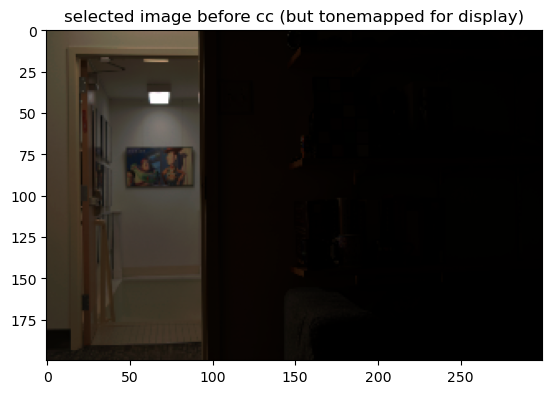

[[ 3.61703329 -0.33407186  0.01748401  0.        ]
 [ 0.05314057  5.06593857  0.02381178  0.        ]
 [-0.71953686  1.23791341  7.48922813  0.        ]
 [-0.02948246 -0.08137064 -0.11365783  1.        ]]


In [12]:
# Q2) Color Correction and White Mapping
im_hdr_selected = I_hdr_jpeg_lin_merged_w_photon.copy()
color_checker_vals = src.cp_hw2.read_colorchecker_gm()

temp = np.stack((color_checker_vals[0],color_checker_vals[1]), axis=2)
color_checker_vals = np.concatenate((temp,np.expand_dims(color_checker_vals[2],2)),axis=-1)
# array above goes from left bottom to right top, column wise

color_checker_vals_vec = []
for ccvs in color_checker_vals : # col
    for ccv in ccvs : # row in col, ie cell
        color_checker_vals_vec.append(ccv)
# order goes from bo
color_checker_vals_vec = np.array(color_checker_vals_vec)

# %matplotlib qt
im_hdr_selected_tonemapped = display_hdr_image(im_hdr_selected,0.005,'selected image before cc (but tonemapped for display)')
# coords = plt.ginput(n=24,timeout=10000)
# plt.show()
# %matplotlib inline
# src.cp_hw2.writeHDR('im_hdr_selected_tonemapped.HDR', im_hdr_selected_tonemapped)
# src.cp_hw2.writeHDR('im_hdr_selected.HDR', im_hdr_selected)

# order goes from left bottom to right top, column wise
coords = [(168.31288711288718, 73.79570429570433),
 (168.31288711288718, 65.76373626373629),
 (167.50969030969034, 57.73176823176826),
 (167.50969030969034, 48.89660339660341),
 (167.91128871128873, 41.66783216783219),
 (167.10809190809195, 34.037462537462545),
 (175.5416583416584, 73.3941058941059),
 (175.9432567432568, 65.76373626373629),
 (175.9432567432568, 57.73176823176826),
 (175.5416583416584, 48.89660339660341),
 (174.73846153846156, 40.463036963036984),
 (174.73846153846156, 34.037462537462545),
 (184.77842157842164, 73.3941058941059),
 (183.97522477522486, 64.55894105894109),
 (183.17202797202802, 56.928571428571445),
 (182.77042957042963, 49.29820179820183),
 (182.77042957042963, 40.864635364635376),
 (182.77042957042963, 34.439060939060965),
 (191.60559440559447, 73.79570429570433),
 (191.60559440559447, 64.55894105894109),
 (191.20399600399608, 58.13336663336665),
 (190.80239760239763, 49.29820179820183),
 (190.80239760239763, 40.463036963036984),
 (191.60559440559447, 33.23426573426576)]
coords = np.array(coords).astype('int')

colors_in_img = []
for coord in coords : 
    color_avg = im_hdr_selected[coord[1]-2:coord[1]+2,coord[0]-2:coord[0]+2].mean(axis=0).mean(axis=0)
    colors_in_img.append(color_avg)
colors_in_img = np.array(colors_in_img)    

ones = np.ones((colors_in_img.shape[0],1))
color_checker_vals_vec = np.concatenate((color_checker_vals_vec, ones),-1)
colors_in_img = np.concatenate((colors_in_img, ones),-1)

# Solve for X*A = Y. X : Our vals, Y : color checker D65 vals, A : affine transform
A, _, _, _ = np.linalg.lstsq(colors_in_img, color_checker_vals_vec, rcond=None)
A[np.abs(A) < 1e-10] = 0
print(A)

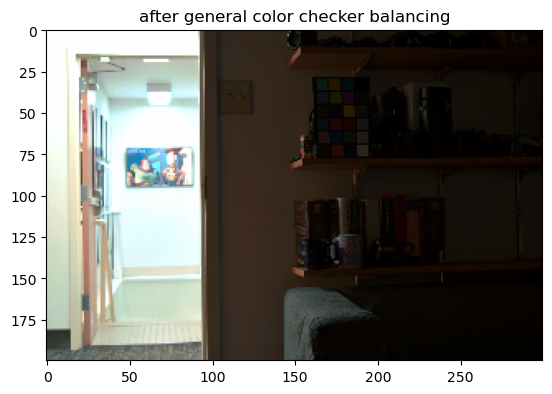

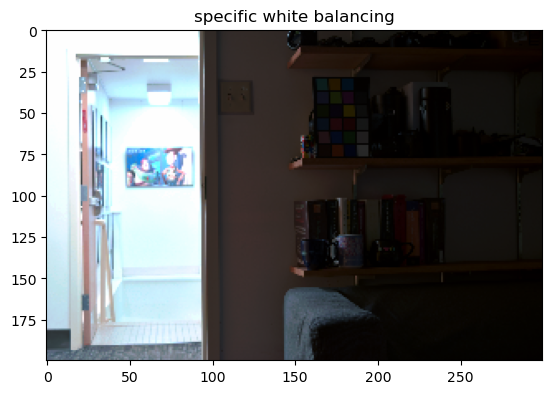

In [13]:
ones_image = np.ones([im_hdr_selected.shape[0],im_hdr_selected.shape[1],1])
im_hdr_selected_homogenous = np.concatenate((im_hdr_selected,ones_image),-1)
im_hdr_selected_cc = np.matmul(im_hdr_selected_homogenous,A)
im_hdr_selected_cc = im_hdr_selected_cc[...,:3]
im_hdr_selected_cc_tonemapped = display_hdr_image(im_hdr_selected_cc,0.02,'after general color checker balancing')
# im_hdr_selected_cc = np.clip(im_hdr_selected_cc,0.0,1.0)
# plt.imshow(im_hdr_selected_cc) 
# plt.show()
# first layer of tonemapping is done
# second layer below
# all vals at white patch should be white
white_patch = im_hdr_selected_cc[coords[-6][1]-2:coords[-6][1]+2,coords[-6][0]-2:coords[-6][0]+2].mean(axis=0).mean(axis=0)
im_hdr_selected_cc_wb = im_hdr_selected_cc.copy()
im_hdr_selected_cc_wb[...,0] = im_hdr_selected_cc[...,0] * white_patch[0] / white_patch[0]
im_hdr_selected_cc_wb[...,1] = im_hdr_selected_cc[...,1] * white_patch[0] / white_patch[1]
im_hdr_selected_cc_wb[...,2] = im_hdr_selected_cc[...,2] * white_patch[0] / white_patch[2]
im_hdr_selected_cc_wb_tonemapped = display_hdr_image(im_hdr_selected_cc_wb,0.02,'specific white balancing')
# src.cp_hw2.writeHDR('im_hdr_selected_cc_tonemapped.HDR', im_hdr_selected_cc_tonemapped)
# src.cp_hw2.writeHDR('im_hdr_selected_cc.HDR', im_hdr_selected_cc)
# src.cp_hw2.writeHDR('im_hdr_selected_cc_wb_tonemapped.HDR', im_hdr_selected_cc_wb_tonemapped)
# src.cp_hw2.writeHDR('im_hdr_selected_cc_wb.HDR', im_hdr_selected_cc_wb)

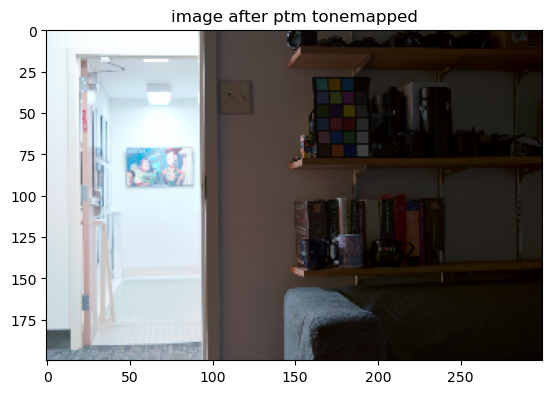

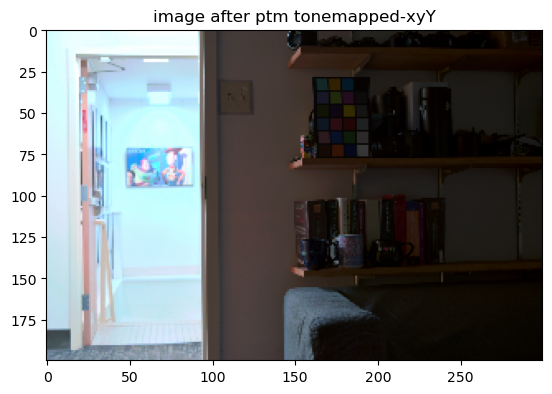

In [14]:
# Photographic ToneMapping

# kinda sus, make sure its right
def calc_geometric_mean_log(im) : 
    
    if im.min() < 0 : 
        # clipping out negative values and raising them to be over 0
        g_mean = np.exp(np.log(im - (1.00000001) * im.min()).mean()) 
    else : 
        # else 
        g_mean = np.exp(np.log(im + 1e5).mean()) 
    
    return g_mean

def calc_geometric_mean(im) : 
    pass

def place_key(g_mean, im, K) : 
    im_keyed= K * (im) / g_mean
    return im_keyed

def set_white(im_keyed, B) : 
    im_white = B * np.max(im_keyed)
    return im_white

# Note : don't really understand what the difference 
# would be upon applying tonemapping for the 3 channels separately
# in the case mentioned in the hints. That would be same as this right?
def complete_photographic_tonemap(im, K, B) :
    
    g_mean = calc_geometric_mean_log(im)
    im_keyed = place_key(g_mean, im, K)
    im_white = set_white(im_keyed, B)
    
    im_tonemapped_num = im_keyed * (1 + im_keyed / (im_white**2))
    im_tonemapped_den = 1 + im_keyed
    
    im_tonemapped = im_tonemapped_num / im_tonemapped_den
    
    return im_tonemapped

def complete_photographic_tonemap_throughxyY(im, K, B) :
    
    im_XYZ = src.cp_hw2.lRGB2XYZ(im)
    x = im_XYZ[...,0] / im_XYZ.sum(2) 
    y = im_XYZ[...,1] / im_XYZ.sum(2)
    Y = im_XYZ[...,1]
    
    Y_tonemapped = complete_photographic_tonemap(Y, K, B)
    
    X = (x * Y_tonemapped) / y
    Y = Y_tonemapped
    Z = (1 - x - y) * Y_tonemapped / y
    
    im_XYZ_tonemapped = np.concatenate((np.stack((X,Y),-1),np.expand_dims(Z,-1)),-1)   
    im_RGB_tonemapped = src.cp_hw2.XYZ2lRGB(im_XYZ_tonemapped)
    
    return im_RGB_tonemapped   

im_hdr_selected_cc_wb_ptm = complete_photographic_tonemap(im_hdr_selected_cc_wb, K=0.09, B=0.95)
im_hdr_selected_cc_wb_ptm_tonemapped = display_hdr_image(im_hdr_selected_cc_wb_ptm, 1.2, 'image after ptm tonemapped')


im_hdr_selected_cc_wb_ptm_xyY = complete_photographic_tonemap_throughxyY(im_hdr_selected_cc_wb, K=0.045, B=0.95)
im_hdr_selected_cc_wb_ptm_tonemapped = display_hdr_image(im_hdr_selected_cc_wb_ptm_xyY, 1.5, 'image after ptm tonemapped-xyY')

In [ ]:
im_hdr_selected_cc_wb_ptm.max()

In [ ]:
np.exp(np.log(np.clip(im_hdr_selected_cc_wb,1e-8,im_hdr_selected_cc_wb.max())).mean())

In [ ]:
np.exp(np.log(im_hdr_selected_cc_wb - (1.00000001) * im_hdr_selected_cc_wb.min()).mean())